# How to load a machine learning model into Azure ML

Azure's automl takes a lot of the steps our of building a custom model. It's very easy to use. While not the best for any use case, it is suitible for most simple prediction problems. This is especially helpful if you aren't sure what kind of model you want, or want to quickly test that you data will produce good results. 

* This is the process for training a model in AutoML on an ad-hoc basis.  

## Basic Steps
1. Munge data into features and targets
2. Upload to an azure storage location
3. Train the model
4. Download the trained model
5. Predict new outcomes using `.predict()` (or whatever you intend to do with the model)

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import altair as alt
from IPython.display import Image

# ml libraries
import azureml
from azureml.core.experiment import Experiment
from azureml.core import Workspace
from azureml.train.automl import AutoMLConfig

from azureml.widgets import RunDetails

from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.compute import ComputeTarget
from azureml.core import Dataset

from sklearn.model_selection import train_test_split

import sys

sys.path.append("..")

pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
%load_ext lab_black

AzureML Is always changing, so it is important to know which version you are using. Newer versions aren't always the best, so make sure to check your version and test your code on a new version before upgrading. 

In [2]:
azureml.core.VERSION

'1.0.74'

# Setup, Configuration and Loading the local data

In order to track everything in `automl tags` (for review and reproducibility purposes), record as many changes in the `tags` dict.  There is no known limit to the number of tags that you can add so feel free to add as many as you think will be useful. Tags can be used to filter and search through model performance at the end of the process. 

In [3]:
# the stated purpose of the model, to avoid confusion with other models.
# Description is the column that shows up in the models view in Azure
description = "experience testing for training course"

#### Extra munging step here:
Add extra code here to add steps so that you can keep the steps above for future users. I'm adding a local file for testing. 

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [5]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

df["species"] = [iris.target_names[x] for x in iris.target]
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa
...,...,...,...,...,...
145,6.70,3.00,5.20,2.30,virginica
146,6.30,2.50,5.00,1.90,virginica
147,6.50,3.00,5.20,2.00,virginica
148,6.20,3.40,5.40,2.30,virginica


In [6]:
alt.Chart(df).mark_circle().encode(
    alt.X(alt.repeat("column"), type="quantitative"),
    alt.Y(alt.repeat("row"), type="quantitative"),
    color="species",
).properties(width=200, height=200).repeat(
    row=list(iris.feature_names), column=list(iris.feature_names)
)

alt.RepeatChart(...)

#### Logging into the Azure Experience 

There are some known issues switching between tenants in `azureml.core.authentication`. So if you have used a different tenant then you may need to specify here. If you are doing this for the first time, a browser window will pop up so that you can authenticate.  


**Note** that this won't work for you as you don't have access to the azure resource, but if you use the ids from your own tennant this will run fine. 
* [docs about the Experiment class](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py) 

In [7]:
interactive_auth = InteractiveLoginAuthentication(
    tenant_id="62f24da8-16e1-4f3b-a913-58b779c623f4"
)
ws = Workspace.get(
    name="pjx-d-cu1-mlw-models",
    subscription_id="3465b147-e7ee-497a-8279-774442465d07",
    resource_group="Project_X_Dev",
    auth=interactive_auth,
)

experiment = Experiment(ws, "workshop")

Uploading the temp datafile to the cloud. 

In [8]:
df.to_csv("../data/iris.csv", index=False)

datastore = ws.get_default_datastore()
datastore.upload_files(
    files=["../data/iris.csv"],
    target_path="train-dataset/tabular/",
    overwrite=True,
    show_progress=True,
)

Uploading an estimated of 1 files
Uploading ../data/iris.csv
Uploaded ../data/iris.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_a4f87e17fbc04e638c0c899aad4a83ef

In [9]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa
...,...,...,...,...,...
145,6.70,3.00,5.20,2.30,virginica
146,6.30,2.50,5.00,1.90,virginica
147,6.50,3.00,5.20,2.00,virginica
148,6.20,3.40,5.40,2.30,virginica


In [10]:
dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, "train-dataset/tabular/iris.csv")]
)

training_data, validation_data = dataset.random_split(percentage=0.8, seed=42)

In [11]:
training_data.to_pandas_dataframe()

C:\Users\willi\Anaconda3\envs\azure\lib\site-packages\azureml\dataprep\api\dataflow.py:689: UserWarning: Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install azureml-dataprep[pandas].
  warnings.warn('Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. '


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,4.90,3.00,1.40,0.20,setosa
1,4.70,3.20,1.30,0.20,setosa
2,4.60,3.10,1.50,0.20,setosa
3,5.00,3.60,1.40,0.20,setosa
4,5.40,3.90,1.70,0.40,setosa
...,...,...,...,...,...
121,6.70,3.00,5.20,2.30,virginica
122,6.30,2.50,5.00,1.90,virginica
123,6.50,3.00,5.20,2.00,virginica
124,6.20,3.40,5.40,2.30,virginica


In [12]:
training_data

{
  "source": [
    "('factset', 'train-dataset/tabular/iris.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes",
    "RandomSplit"
  ]
}

Defining the remote compute resource that will do the actual training. 

In [13]:
compute_name = "MLWorker1"

compute_target = ComputeTarget(workspace=ws, name=compute_name)
compute_target

AmlCompute(workspace=Workspace.create(name='pjx-d-cu1-mlw-models', subscription_id='3465b147-e7ee-497a-8279-774442465d07', resource_group='Project_X_Dev'), name=MLWorker1, id=/subscriptions/3465b147-e7ee-497a-8279-774442465d07/resourceGroups/Project_X_Dev/providers/Microsoft.MachineLearningServices/workspaces/pjx-d-cu1-mlw-models/computes/MLWorker1, type=AmlCompute, provisioning_state=Succeeded, location=westus2, tags=None)

# Running the Model 

In [14]:
azureml.train.automl.utilities.get_primary_metrics("classification")

['average_precision_score_weighted',
 'AUC_weighted',
 'precision_score_weighted',
 'norm_macro_recall',
 'accuracy']

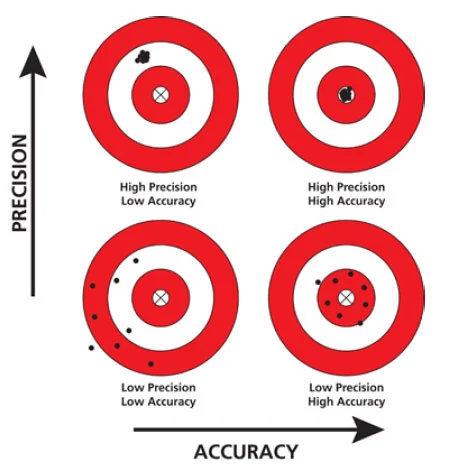

In [15]:
Image("../images/precisionvaccuracy.png")

All the relevant tags are used in the experiment run. This is important for both QA and keeping track of your model. 

In [16]:
# Tags for experiment documentation
tags = {
    "targets": "species",
    "random_state": 42,
    "description": description,
}

The run here is submitted to the cloud where it is run as an experiment. 

In [18]:
automl_config = AutoMLConfig(
    task="classification",
    training_data=training_data,
    label_column_name="species",
    experiment_timeout_minutes=60,
    model_explainability=True,
    primary_metric="accuracy",
    compute_target=compute_target,
)

run = experiment.submit(config=automl_config, tags=tags)

WARNING - Converting non-string tag to string: (random_state: 42)


You can click on the URL below to see the run as it is in progress. This will also give you any metadata about that run. 

In [19]:
print(run.get_portal_url())

https://ml.azure.com/experiments/workshop/runs/AutoML_efd15a94-1101-4567-9b3c-b16273cdb682?wsid=/subscriptions/3465b147-e7ee-497a-8279-774442465d07/resourcegroups/Project_X_Dev/workspaces/pjx-d-cu1-mlw-models


If you are running in `jupyter notebooks` as opposed to `jupyter lab` the `RunDetails(run).show()` will show a GUID that will demonstrate the results of the experiment and the different KPIs for that run. 

In [20]:
RunDetails(run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

This command will pause the kernel until the run comes back successfully. This is not required as the run can take a long time to complete. However, this is a good way to run the entire script from start to finish. 

In [23]:
# uncomment to run
results = run.wait_for_completion(show_output=True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   MaxAbsScaler LightGBM                          0:00:44       0.9372    0.9372
         1   MinMaxScaler SGD                               0:00:52       0.8750    0.9372
         2   StandardScalerWrapper ExtremeRandomTrees       0:00:43       0.9679    0.9679
         3   MinMaxScaler SGD                               0:00:44       0.6974    0.9679
         4   RobustScaler ExtremeRandomTrees                0:00:44       0.8833    

You can see the success of the run on various models, plus the link to the azure portal where you can see the results of **all** of the runs that have been created thus far. It will also show you all the models that it used and the performance of each. There is a lot more detail on the experiment runs in the Azure portal. 

## Getting the best model out of our experiment

The best run is usually some kind of `VotingEnsemble`

* AzureML provides us with get_output() to get the best pipeline from the iterations of our experiment<br/>
* You can also fetch a specific model by getting the run id from the azure portal. 
* We then save the best run and best fitted model from this pipeline<br/>
[AzureML-Retrieve the best model](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-auto-train-models#retrieve-the-best-model)

You can pull any model using a specific run id from the Azure portal. 

In [24]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: workshop,
Id: AutoML_efd15a94-1101-4567-9b3c-b16273cdb682_65,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('stackensembleclassifier', StackEnsembleClassifier(base_learners=[('27', PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('SparseNormalizer', <automl.client.core.runtime.model_wrappers.SparseNormalizer object at 0x000001EE75BC3F28>), ('ExtraTreesClassifier', ExtraTreesClassi...olver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            training_cv_folds=5))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [25]:
df_test = validation_data.to_pandas_dataframe()
df_test

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.10,3.50,1.40,0.20,setosa
1,4.80,3.40,1.60,0.20,setosa
2,5.70,4.40,1.50,0.40,setosa
3,5.10,3.70,1.50,0.40,setosa
4,5.00,3.00,1.60,0.20,setosa
...,...,...,...,...,...
19,6.40,3.20,5.30,2.30,virginica
20,6.40,2.80,5.60,2.20,virginica
21,6.10,2.60,5.60,1.40,virginica
22,6.30,3.40,5.60,2.40,virginica


## Testing the model against new data

Before training the model, we put aside a certain amount of data with `validation_data`. Now that the model selection is complete, we can use that set to determine how well the model performs against net new companies (companies that it has never seen data for). If the model is _good_ it should predict close to the same as the known amount.   

In [32]:
test = pd.DataFrame(df_test["species"].values, index=df_test.index, columns=["actual"])
test["predicted"] = list(fitted_model.predict(df_test.drop("species", axis=1)))

test["err"] = test["actual"] == test["predicted"]
test.sort_values(["err"])

,actual,predicted,err
0,setosa,setosa,True
21,virginica,virginica,True
20,virginica,virginica,True
19,virginica,virginica,True
18,virginica,virginica,True
...,...,...,...
3,setosa,setosa,True
2,setosa,setosa,True
1,setosa,setosa,True
22,virginica,virginica,True


For a clasification, we can look at the results with a confusion matrix. 

In [33]:
test.groupby(["actual", "predicted"]).count().unstack()

err                     
predicted  setosa versicolor virginica
actual                                
setosa       9.00        nan       nan
versicolor    nan       7.00       nan
virginica     nan        nan      8.00

## Explaining the best model with SHAP values 

* Next, we can create an [explainer](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#explainers) object for our best fitted model. This is a permutation feature importance explainer, in our case it is used to explain our regression, which is based off of [Breiman's Random Forests Paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf).<br/> 

* Then we can explain our model locally using the [explain_global](https://docs.microsoft.com/en-us/python/api/azureml-explain-model/azureml.explain.model.permutation.permutation_importance.pfiexplainer?view=azure-ml-py#explain-global-evaluation-examples--true-labels-) method to get our explanation.<br/> 

* Finally, we can use the get_ranked_glboal_values method to get a list of our importance values. 

### A more detailed guide can be found [here.](https://docs.microsoft.com/en-us/azure/machine-learning/service/machine-learning-interpretability-explainability#train-and-explain-locally) 

In [34]:
from azureml.explain.model._internal.explanation_client import ExplanationClient

client = ExplanationClient.from_run(best_run)

In [35]:
engineered_explanation = client.download_model_explanation(raw=False)

In [36]:
from azureml.explain.model.shap import KernelExplainer

explainer = KernelExplainer(fitted_model, df[iris.feature_names])

local_explanation = explainer.explain_local(df[iris.feature_names])
local_explanation

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.26it/s]


In [37]:
global_explanation = explainer.explain_global(df[iris.feature_names])

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.91it/s]


In a regression model, the `global_explanation.expected_values` is the equivilant of an x-intercept for the predicted values. We'll come back to this in a second. 

In [38]:
global_explanation.expected_values

[0.29878274733905796, 0.34128291011067186, 0.35993434255027024]

The `global_explanation.get_feature_importance_dict` in a regression model is a proxy for the coeficient of each feature.

In [39]:
shap_global = pd.Series(global_explanation.get_feature_importance_dict())
shap_global

petal length (cm)   0.24
petal width (cm)    0.11
sepal length (cm)   0.03
sepal width (cm)    0.01
dtype: float64

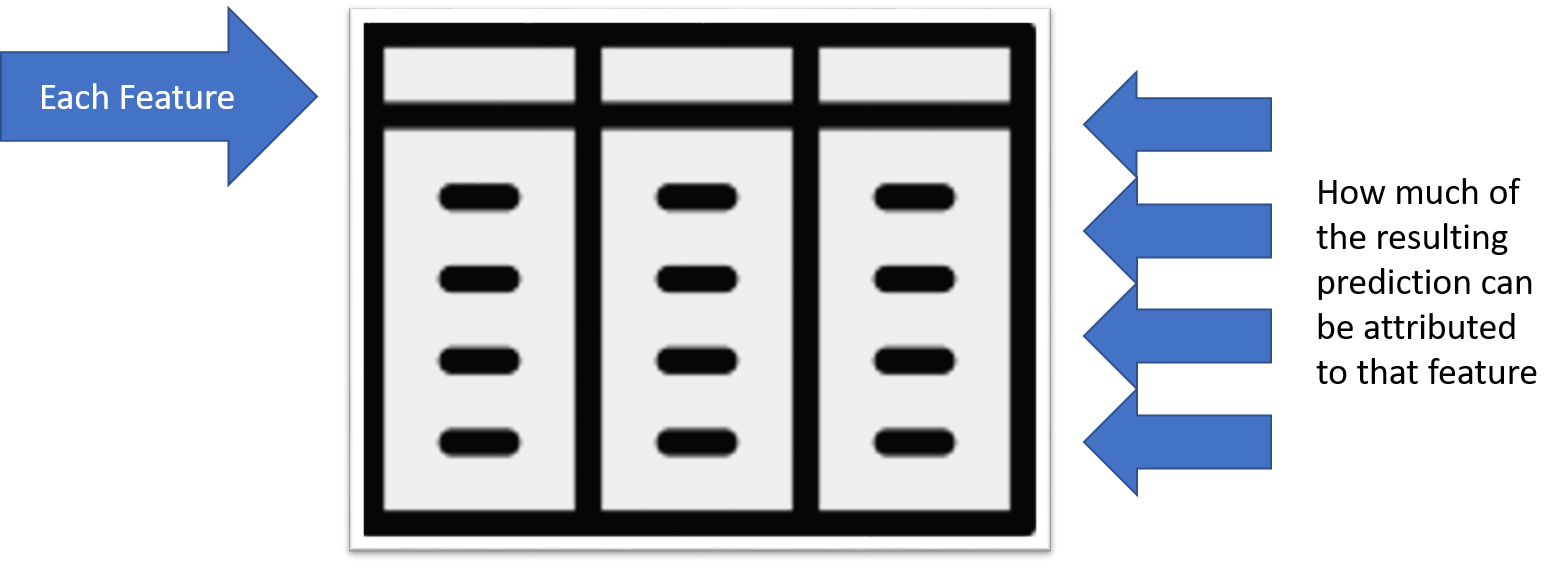

In [47]:
Image("../images/shap_class.png")

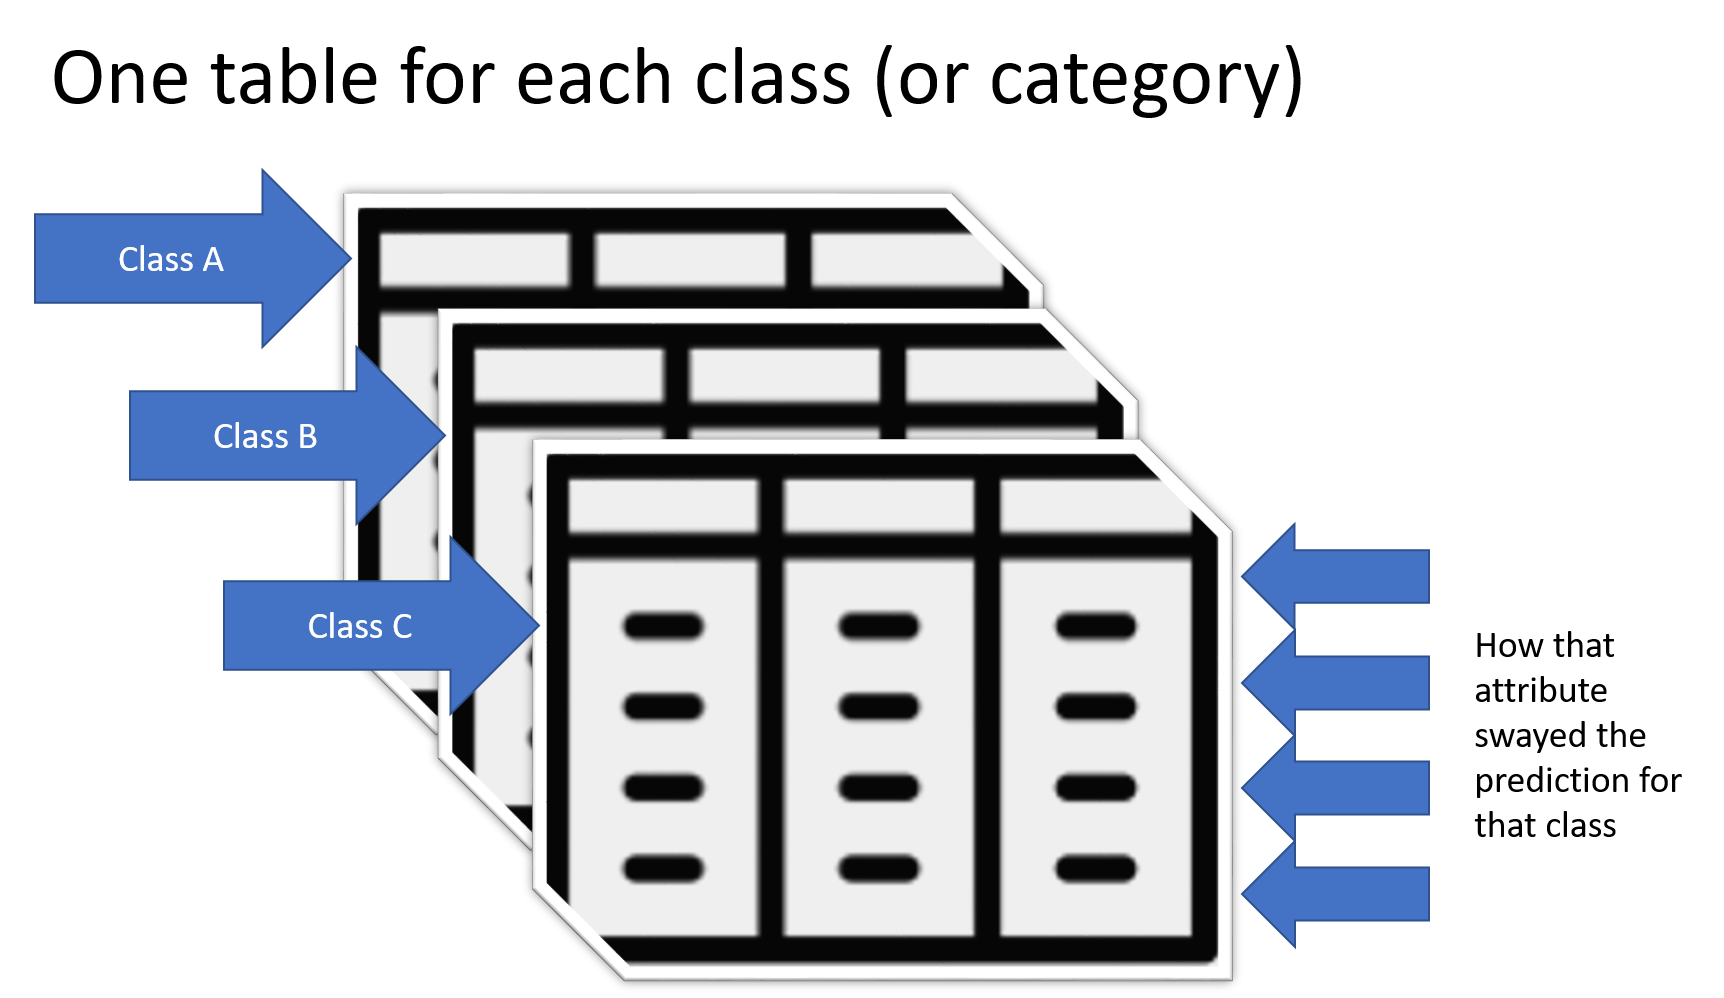

In [50]:
Image("../images/shap_class2.png")

In [48]:
pd.DataFrame(local_explanation.get_ranked_local_values()[0])

,0,1,2,3
0,0.34,0.14,0.03,0.02
1,0.34,0.14,0.04,0.00
2,0.34,0.14,0.04,0.01
3,0.34,0.15,0.04,0.01
4,0.33,0.15,0.03,0.02
...,...,...,...,...
145,-0.01,-0.02,-0.07,-0.17
146,-0.02,-0.02,-0.07,-0.16
147,-0.01,-0.02,-0.08,-0.17
148,0.00,-0.02,-0.07,-0.18


The process of getting the local values from the `local_explanation` is convoluted, however the end result is the per row/ per feature _attribution_ to the predicted value. It shows you how much the feature value contribues to the ending prediction. 

In [49]:
pd.DataFrame(local_explanation.get_ranked_local_names()[0])

,0,1,2,3
0,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
1,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
2,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
3,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
4,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
...,...,...,...,...
145,sepal width (cm),sepal length (cm),petal width (cm),petal length (cm)
146,sepal width (cm),sepal length (cm),petal width (cm),petal length (cm)
147,sepal width (cm),sepal length (cm),petal width (cm),petal length (cm)
148,sepal width (cm),sepal length (cm),petal width (cm),petal length (cm)


In [51]:
def align_shap(names, values):
    df = pd.DataFrame(values, index=names).T
    return df


dfs = []
for i in range(np.array(local_explanation.get_ranked_local_values()).shape[0]):
    names = pd.DataFrame(local_explanation.get_ranked_local_names()[i])
    values = pd.DataFrame(local_explanation.get_ranked_local_values()[i])
    dfs.append(
        pd.concat(
            [
                pd.DataFrame(values.loc[i].values, index=names.loc[i].values).T
                for i in names.index
            ]
        ).reset_index(drop=True)
    )

dfs[0]

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
0,0.34,0.14,0.03,0.02
1,0.34,0.14,0.04,0.00
2,0.34,0.14,0.04,0.01
3,0.34,0.15,0.04,0.01
4,0.33,0.15,0.03,0.02
...,...,...,...,...
145,-0.17,-0.07,-0.02,-0.01
146,-0.16,-0.07,-0.02,-0.02
147,-0.17,-0.08,-0.02,-0.01
148,-0.18,-0.07,-0.02,0.00


In [52]:
dfs[1]

,sepal width (cm),sepal length (cm),petal width (cm),petal length (cm)
0,-0.00,-0.03,-0.07,-0.15
1,0.00,-0.04,-0.07,-0.14
2,-0.00,-0.05,-0.07,-0.14
3,-0.00,-0.05,-0.07,-0.13
4,-0.00,-0.04,-0.07,-0.15
...,...,...,...,...
145,0.00,0.06,-0.21,-0.16
146,-0.02,0.01,-0.13,-0.15
147,-0.00,0.01,-0.11,-0.20
148,0.03,-0.00,-0.13,-0.19


A rough approximation for the shap values can be explained as: 

$\sum_{i=0}^{n}\beta_{i}*(x_{i}-\bar{x})\space where\space n=|features|$

However the API does some other weights and scalings depending on the model type and nature of the imput values. 

Note in `df_prediction` above that the prediction and shap values don't exactly match. **However** the `shap` value, plus the `global_explanation.expected_values` (or y intercept point) adds up to the exact prediction. This is how we attribute each feature to the outcome. It also gives us an individual feature contribution for each row (or company). 

In [53]:
dfs[0]

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
0,0.34,0.14,0.03,0.02
1,0.34,0.14,0.04,0.00
2,0.34,0.14,0.04,0.01
3,0.34,0.15,0.04,0.01
4,0.33,0.15,0.03,0.02
...,...,...,...,...
145,-0.17,-0.07,-0.02,-0.01
146,-0.16,-0.07,-0.02,-0.02
147,-0.17,-0.08,-0.02,-0.01
148,-0.18,-0.07,-0.02,0.00


In [54]:
print(iris.target_names)
print(iris.feature_names)
prediction = 0
feature = "sepal width (cm)"

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [55]:
chart_df = pd.concat(
    [dfs[prediction].rename(columns={c: f"s_{c}" for c in dfs[1].columns}), df], axis=1
)

chart_df

,s_petal length (cm),s_petal width (cm),s_sepal length (cm),s_sepal width (cm),sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.34,0.14,0.03,0.02,5.10,3.50,1.40,0.20,setosa
1,0.34,0.14,0.04,0.00,4.90,3.00,1.40,0.20,setosa
2,0.34,0.14,0.04,0.01,4.70,3.20,1.30,0.20,setosa
3,0.34,0.15,0.04,0.01,4.60,3.10,1.50,0.20,setosa
4,0.33,0.15,0.03,0.02,5.00,3.60,1.40,0.20,setosa
...,...,...,...,...,...,...,...,...,...
145,-0.17,-0.07,-0.02,-0.01,6.70,3.00,5.20,2.30,virginica
146,-0.16,-0.07,-0.02,-0.02,6.30,2.50,5.00,1.90,virginica
147,-0.17,-0.08,-0.02,-0.01,6.50,3.00,5.20,2.00,virginica
148,-0.18,-0.07,-0.02,0.00,6.20,3.40,5.40,2.30,virginica


In [58]:
alt.Chart(chart_df).mark_point().encode(
    x=feature, y=f"s_{feature}", color="species"
).properties(title=f"predicting {iris.target_names[prediction]}")

alt.Chart(...)

In [60]:
compare_prediction = 1
chart_df = pd.concat(
    [dfs[compare_prediction].rename(columns={c: f"s_{c}" for c in dfs[1].columns}), df],
    axis=1,
)

alt.Chart(chart_df).mark_point().encode(
    x=feature, y=f"s_{feature}", color="species"
).properties(title=f"predicting {iris.target_names[compare_prediction]}")

alt.Chart(...)

# Depoloying the model

If the model is approved, submit the model to the automl library so that others can use it. It's commented out as a default as you may not want to save each idividual model. 

Here I like to add a description as it shows up in the models tab of the azure workspace. 

In [61]:
run.register_model(
    tags=tags, description=description + " - tested at " + str(test["err"].mean())
)

Model(workspace=Workspace.create(name='pjx-d-cu1-mlw-models', subscription_id='3465b147-e7ee-497a-8279-774442465d07', resource_group='Project_X_Dev'), name=AutoMLefd15a94165, id=AutoMLefd15a94165:1, version=1, tags={'targets': 'species', 'random_state': '42', 'description': 'experience testing for training course'}, properties={})

In [62]:
fitted_model.named_steps

{'stackensembleclassifier': StackEnsembleClassifier(base_learners=[('27', PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('SparseNormalizer', <automl.client.core.runtime.model_wrappers.SparseNormalizer object at 0x000001EE75BC3F28>), ('ExtraTreesClassifier', ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy'...rbose=0, warm_start=False))]},
                y_transformer={}, y_transformer_name='LabelEncoder'))],
             meta_learner=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
             training_cv_folds=5)}

In [63]:
import pickle

In [68]:
pickle.dump(
    dfs, open("../data/shapley_values.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL
)
pickle.dump(
    fitted_model, open("../data/fitted_model.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL
)